# Домашнее задание по теме «Ансамблирование»

In [1]:
# Подклюим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Загрузим данные
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Разделяем на тренировочные и тестовые данные
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [6]:
# Находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

# Закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
# Пропущенные значения в категориальных признаках в данном случае скорее всего означает, что этого признака нет у объекта
data[categorials] = data[categorials].fillna('nan')

In [10]:
#отфильтруем непрерывные признаки
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [11]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

In [18]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,RoofMatl_CompShg,BsmtFinType1_ALQ,MiscFeature_Gar2,SaleType_New,ExterCond_Fa,HeatingQC_Gd,Exterior1st_CemntBd,KitchenQual_TA,Fence_GdPrv,SaleType_ConLD
135,136,20,80.0,10400,7,6,1970,1970,288.0,0,...,1,0,0,0,0,1,0,1,0,0
1452,1453,180,35.0,3675,5,5,2005,2005,80.0,547,...,1,0,0,0,0,1,0,1,0,0
762,763,60,72.0,8640,7,5,2009,2009,0.0,24,...,1,0,0,0,0,0,0,0,0,0
932,933,20,84.0,11670,9,5,2006,2006,302.0,0,...,1,0,0,0,0,0,0,0,0,0
435,436,60,43.0,10667,7,6,1996,1996,0.0,385,...,1,0,0,0,0,0,0,0,0,0


Построим случайный лес

In [19]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

RandomForestRegressor()

In [20]:
# Проверяем полученные данные на тренировочных данных

clf_rf.score(X_train, y_train)

0.975124864990757

In [21]:
# Проверяем полученные данные на тестовых данных

clf_rf.score(X_test, y_test)

# Модель получилась не много переобученной

0.8921261436496365

Качество получилось весьма высокое

In [22]:
# Выявляем наиболее важные признаки и выводим на график. Большое значение имеет признак Overall Qual, остальные почти равны нулю

imp = pd.Series(clf_rf.feature_importances_)

In [23]:
imp.index = pd.Series(X_train.columns)

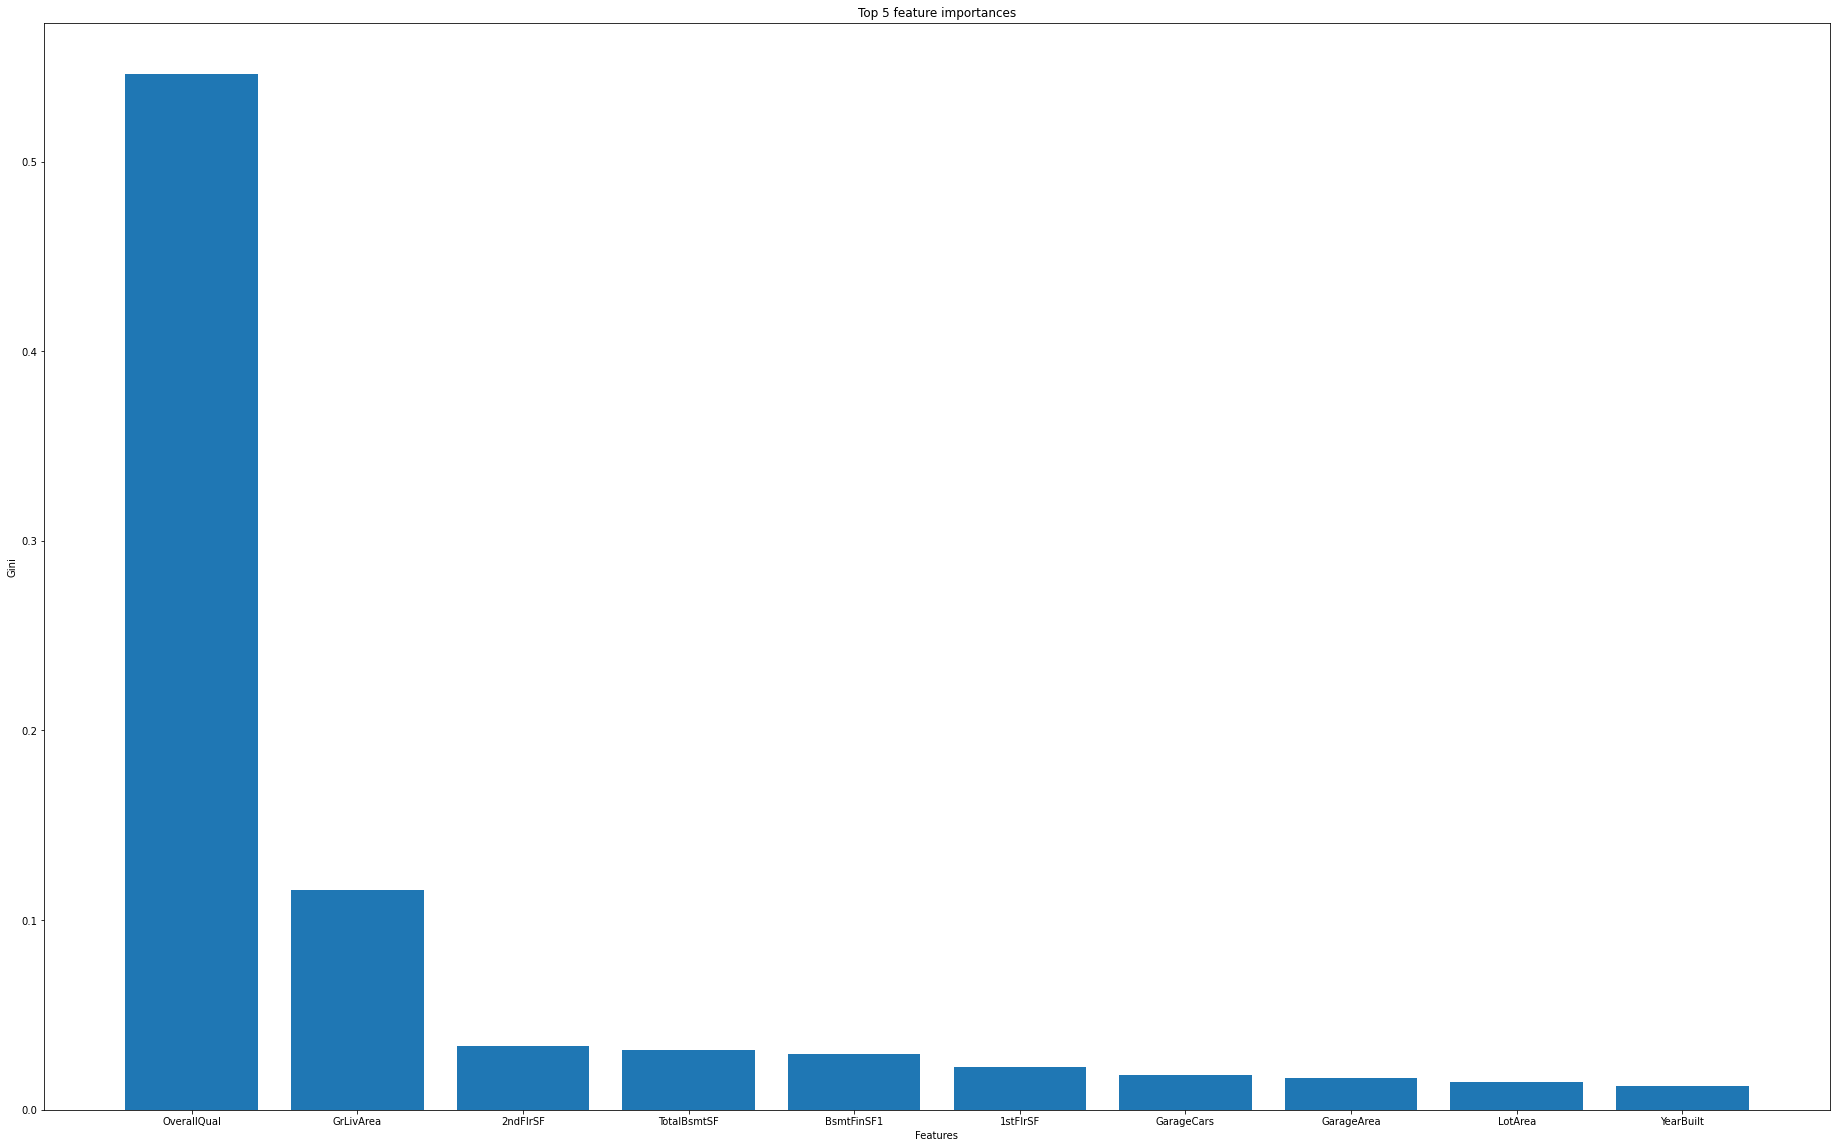

In [26]:
plt.figure(figsize=(32,20))
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head(10).index, imp.sort_values(ascending=False).head(10))
plt.show()

Обучим стекинг: вкачестве базовых моделе возьмем: линейную регрессию, метод к-ближайших соседей и тот же случайный лес.\
В качестве мета-алгоритма используем RidgeCV-регрессию.

In [32]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [34]:
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('RandomForest', RandomForestRegressor())
    ], RidgeCV())

In [35]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('RandomForest', RandomForestRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [36]:
print(f'Оценка качества на train {Regressor.score(X_train, y_train)}')
print(f'Оценка качества на test {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Оценка качества на train модели {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Оценка качества на test модели {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Оценка качества на train 0.9712378365810312
Оценка качества на test 0.8999173109455807
Оценка качества на train модели LinearRegression 0.922108540356243
Оценка качества на test модели LinearRegression 0.8533836050579163
Оценка качества на train модели KNeighborsRegressor 0.7419951520813983
Оценка качества на test модели KNeighborsRegressor 0.6775304068635524
Оценка качества на train модели RandomForest 0.9775469279687903
Оценка качества на test модели RandomForest 0.8883815927827996


### Итого:
Качество улучшилось с 0.8921261436496365 до 0.8999173109455807 на тестовой выборке. Т.е. ансамбирование помогло улучшить модель на 0,7% - мне кажется совсем немного\
Лучше всего в ансамбле показал себя случайный лес, хуже всего показал - к-ближайших соседей, что неудивительно.\
Линейная регрессия и к-ближайших соседей помогли скорректировать результат случайного леса и улучшить его результат на 1,1%